# Double pendulum
---
*Final version created on 04/30/2021 -- Jessica Kulp -- kulp.95@osu.edu*
#### In this notebook:
* Defines a DoublePendulum class which is used to solve the double pendulum and generate $\phi_i(t)$ vs $t$ plots. 
* Demonstrates that the double pendulum system is chaotic by plotting $\Delta\phi_i(t)$ vs $t$. 
* Creates widgets to vary the initial angles of the pendulums.

From Taylor section 11.4, the **total potential and kinetic energies** of the double pendulum are <br><br>

$$
U = (m_1 + m_2)gL_1(1-\cos \phi_1) + m_2gL_2(1-\cos \phi_2) \qquad\qquad\qquad\quad\:\:\text{(11.37)}
$$
$$
T = \frac{1}{2}(m_1 + m_2)L_1^2\dot{\phi}_1^2 + m_2L_1L_2\dot{\phi}_1\dot{\phi}_2 \cos (\phi_1 - \phi_2) + \frac{1}{2}m_2L_2^2\dot{\phi}_2^2 \qquad\quad \text{(11.38)}
$$<br><br>

Where $\phi_i$, $m_i$, and $L_i$ for $i = 1, 2$ are the angles, masses, and lengths of the two pendulums as shown below.

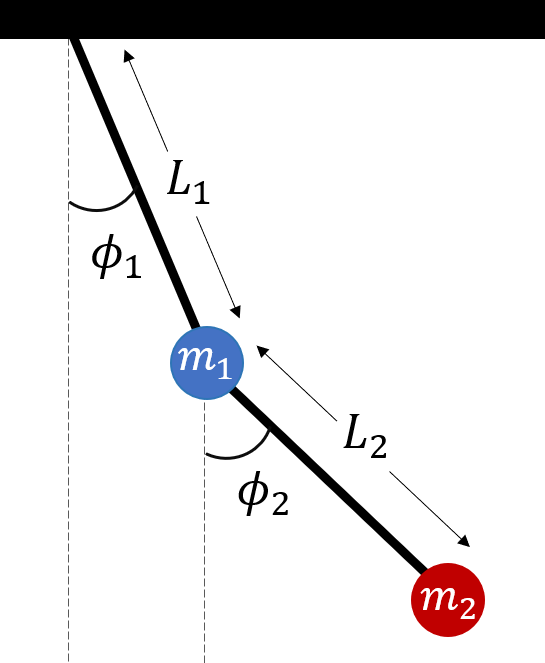

In [1]:
from IPython.display import Image
Image(filename='pendimage.png', width=400)

Giving the **Lagrangian**, $\mathscr{L} = T - U$ <br><br>

$$
\mathscr{L} = \frac{1}{2}(m_1 + m_2)L_1^2\dot{\phi}_1^2 + m_2L_1L_2\dot{\phi}_1\dot{\phi}_2 \cos (\phi_1 - \phi_2) + \frac{1}{2}m_2L_2^2\dot{\phi}_2^2 - (m_1 + m_2)gL_1(1-\cos \phi_1) - m_2gL_2(1-\cos \phi_2) 
$$ <br><br>

We can use the **Euler-Lagrange equations** $\displaystyle \frac{d}{dt} \frac{\partial \mathscr{L}}{\partial \dot{\phi}_i} = \frac{\partial \mathscr{L}}{\partial \phi_i}$ for $i = 1, 2$ (the two angles) to find <br><br>

$$
(m_1 + m_2)L_1 \ddot{\phi}_1 + m_2L_2\ddot{\phi}_2 \cos (\phi_1 - \phi_2) + m_2L_2\dot{\phi}_2^2\sin(\phi_1 - \phi_2) + (m_1 + m_2)g\sin\phi_1 = 0 \qquad (1)
$$
$$
m_2L_2\ddot{\phi}_2 + m_2L_1\ddot{\phi}_1\cos(\phi_1-\phi_2) - m_2L_1\dot{\phi}_1^2\sin(\phi_1-\phi_2) + m_2g\sin\phi_2 = 0 \qquad\qquad\qquad\quad \:(2)
$$<br><br>

We will introduce new variables, $z_i = \dot{\phi}_i \to \dot{z}_i = \ddot{\phi}_i$ (for $i = 1, 2$). This is because we want to use **integrate.solve_ivp** as our ODE solver and it only works with first-order differential equations. We can rearrange the equations above to find $\dot{z}_i$<br><br>

$$
\dot{z}_1 = \big(L_1(m_1 + m_2 \sin^2(\phi_1 - \phi_2))\big)^{-1}\big(m_2g\sin\phi_2\cos(\phi_1-\phi_2) - m_2\sin(\phi_1-\phi_2)(L_1z_1^2\cos(\phi_1 - \phi_2) + L_2z_2^2)-(m_1+m_2)g\sin\phi_1\big)
$$
$$
\dot{z}_2 = \big(L_2(m_1 + m_2 \sin^2(\phi_1-\phi_2))\big)^{-1} \big((m_1+m_2)(L_1z_1^2\sin(\phi_1-\phi_2) + g(\sin\phi_1\cos(\phi_1-\phi_2) - \sin\phi_2))+m_2L_2z_2^2\sin(\phi_1-\phi_2)\cos(\phi_1-\phi_2)\big)
$$

First we import the modules we need.

In [2]:
%matplotlib inline
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

Then we define the **DoublePendulum** class.

In [3]:
class DoublePendulum():
    '''
    The DoublePendulum class contains the parameters, Lagrangian, and Euler-Lagrange equations for 
    a double pendulum with no damping or driving.
    _____________
    Parameters:
    L1 -- float, length of first pendulum
    L2 -- float, length of second pendulum
    m1 -- float, mass of first pendulum bob
    m2 -- float, mass of second pendulum bob
    g  -- float, gravitational acceleration
    _____________
    Methods: 
    dy_dt(t, y) -- Returns the right side of the differential equation at a given time, t, and y value.
    
    '''
    def __init__(self, L1=1., L2=1., m1=1., m2=1., g=1.):
        '''
        Initializes the class attributes. 
        '''
        self.L1 = L1
        self.L2 = L2
        self.m1 = m1
        self.m2 = m2
        self.g = g
        
    def dy_dt(self, t, y):
        '''
        Returns the right side of the differential equation:
        [dphi_1/dt, d^2phi_1/dt^2, dphi_2/dt, d^2phi_2/dt^2]
        ______________
        Parameters: 
        t -- float, time
        y -- float, vector where
             y[0] = phi_1, y[1] = phi_1_dot, y[2] = phi_2, y[3] = phi_2_dot
        ______________
        Returns: 
        [z1, z1_dot, z2, z2_dot] where z1 and z2 are dphi_1/dt and dphi_2/dt (as above)
        '''
        phi_1, z1, phi_2, z2 = y
        delta_phi = phi_1 - phi_2       # difference between phi_1 and phi_2
        mtot = self.m1 + self.m2        # combined mass of the two pendulum bobs
        
        a1 = 1./(self.L1*(self.m1+self.m2*np.sin(delta_phi)**2.))        # terms in z1_dot 
        b1 = self.m2*self.g*np.sin(phi_2)*np.cos(delta_phi)
        c1 = self.m2*np.sin(delta_phi)*(self.L1*z1**2.*np.cos(delta_phi)+self.L2*z2**2.)
        d1 = (mtot)*self.g*np.sin(phi_1)
        
        a2 = 1./(self.L2*(self.m1+self.m2*np.sin(delta_phi)**2.))        # terms in z2_dot
        b2 = (mtot)*(self.L1*z1**2.*np.sin(delta_phi)-self.g*np.sin(phi_2)+self.g*np.sin(phi_1)*np.cos(delta_phi))
        c2 = self.m2*self.L2*z2**2.*np.sin(delta_phi)*np.cos(delta_phi)
    
        z1_dot = a1 * (b1 - c1 - d1)    # combine the terms appropriately
        z2_dot = a2 * (b2 + c2)
        
        return z1, z1_dot, z2, z2_dot
    
    def solve_ode(self, t_pts, phi_1_0, phi_1_dot_0, phi_2_0, phi_2_dot_0, abserr=1.0e-10, relerr=1.0e-10):
        '''
        Solves the ODE given initial conditions.
        '''
        y = [phi_1_0, phi_1_dot_0, phi_2_0, phi_2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        phi_1, phi_1_dot, phi_2, phi_2_dot = solution.y

        return phi_1, phi_1_dot, phi_2, phi_2_dot
    
    def calc_L(y):
        '''
        Returns the Lagrangian, L = T - U
        '''
        phi_1, phi_1_dot, phi_2, phi_2_dot = y.T
        delta_phi = phi_1 - phi_2
        mtot = m1 + m2 
        
        # total potential energy
        U = (mtot)*g*L1*(1.-np.cos(phi_1)) + m2*g*L2*(1.-np.cos(phi_2))
        # total kinetic energy
        T = 0.5*(mtot)*L1**2.*phi_1_dot**2.+0.5*m2*L2**2.*phi_2_dot**2.+m2*L1*L2*phi_1_dot*phi_2_dot*np.cos(delta_phi) 
        
        return T - U

Now we define a function for plotting.

In [4]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

And a function which returns stop and start indices for plotting. 

In [5]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

Getting ready to plot, we define labels for the axes, the plotting time, and the parameters, and instantiate a DoublePendulum object.

In [6]:
# Labels for individual plot axes
phi_vs_time_labels = (r'$t$', r'$\phi(t)$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

L1 = 1.
L2 = 1.
g = 1.
m1 = 1.
m2 = 1.

# Instantiate a double pendulum 
p1 = DoublePendulum(L1=L1, L2=L2, m1=m1, m2=m2, g=g)

Finally, define the initial conditions, solve given the initial conditions using **solve_ode()** (defined in the class), and plot $\phi_i(t)$ vs $t$.

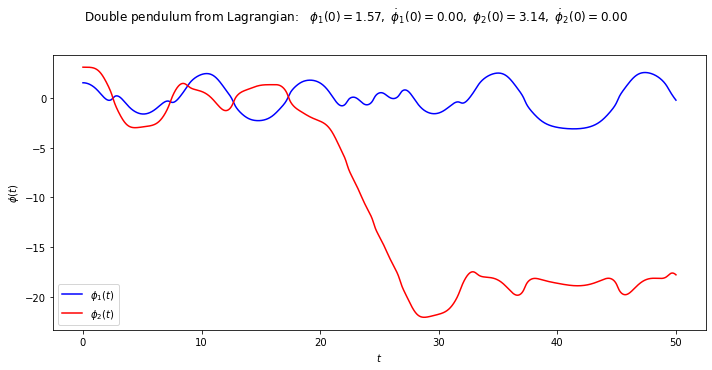

In [7]:
# Set initial conditions -- start at rest
phi_1_0 = np.pi/2.
phi_1_dot_0 = 0.
phi_2_0 = np.pi
phi_2_dot_0 = 0.

# Solve given the initial conditions
phi_1, phi_1_dot, phi_2, phi_2_dot = p1.solve_ode(t_pts, phi_1_0, phi_1_dot_0, phi_2_0, phi_2_dot_0)

# Start the plot!
# Set figure size and title
fig = plt.figure(figsize=(10,5)) 
overall_title = 'Double pendulum from Lagrangian:  ' + \
                rf' $\phi_1(0) = {phi_1_0:.2f},$' + \
                rf' $\dot\phi_1(0) = {phi_1_dot_0:.2f},$' + \
                rf' $\phi_2(0) = {phi_2_0:.2f},$' + \
                rf' $\dot\phi_2(0) = {phi_2_dot_0:.2f}$' 
fig.suptitle(overall_title, va='baseline')
    
ax_a = fig.add_subplot(1,1,1)                  

# Get start/stop indices and plot phi_i vs t using the plotting function 
start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi_1[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='blue',
            label=r'$\phi_1(t)$', 
            ax=ax_a)  
plot_y_vs_x(t_pts[start : stop], phi_2[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='red',
            label=r'$\phi_2(t)$',  
            ax=ax_a)  
fig.tight_layout()
fig.savefig('DoublePendulum.png', bbox_inches='tight')

Here we see the plot of $\phi(t)$ vs $t$ for both angles. The motion appears to be chaotic, but we can check that this system is sensitive to initial conditions by plotting $\Delta\phi(t)$ vs $t$. <br><br>

We will solve for two sets of initial conditions which are only slightly different. Here, we have only changed $\phi_1(0)$ by 0.00001. Then we plot the difference, $\Delta\phi(t)$, for both angles. 

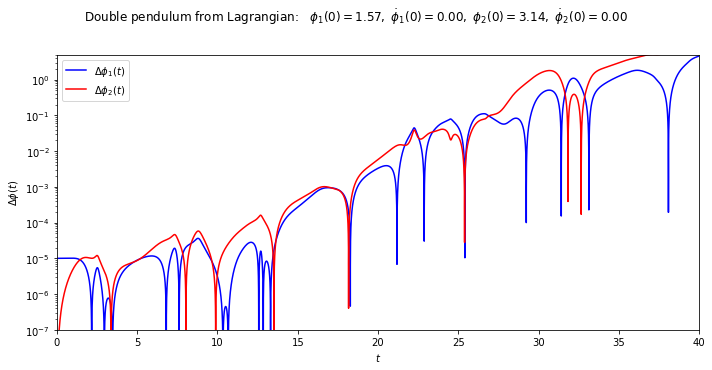

In [8]:
# Solve for two sets of slightly different initial conditions
phi_1, phi_1_dot, phi_2, phi_2_dot = p1.solve_ode(t_pts, phi_1_0, phi_1_dot_0, phi_2_0, phi_2_dot_0)
phi_1b, phi_1b_dot, phi_2b, phi_2b_dot = p1.solve_ode(t_pts, phi_1_0+0.00001, phi_1_dot_0, phi_2_0, phi_2_dot_0)

# Labels for individual plot axes
delta_phi_vs_time_labels = (r'$t$', r'$\Delta\phi(t)$')

# Start the plot!
fig = plt.figure(figsize=(10,5))
overall_title = 'Double pendulum from Lagrangian:  ' + \
                rf' $\phi_1(0) = {phi_1_0:.2f},$' + \
                rf' $\dot\phi_1(0) = {phi_1_dot_0:.2f},$' + \
                rf' $\phi_2(0) = {phi_2_0:.2f},$' + \
                rf' $\dot\phi_2(0) = {phi_2_dot_0:.2f}$' 
fig.suptitle(overall_title, va='baseline')
    
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], abs(phi_1[start : stop] - phi_1b[start : stop]), 
            axis_labels=delta_phi_vs_time_labels, 
            color='blue',
            semilogy=True, # make it a semilog plot
            label=r'$\Delta\phi_1(t)$',  
            ax=ax_a)  
plot_y_vs_x(t_pts[start : stop], abs(phi_2[start : stop] - phi_2b[start : stop]), 
            axis_labels=delta_phi_vs_time_labels, 
            color='red', 
            semilogy=True,
            label=r'$\Delta\phi_2(t)$', 
            ax=ax_a) 
ax_a.set_ylim(1.e-7, 5.)
ax_a.set_xlim(0., 40.)

fig.tight_layout()
fig.savefig('TestForChaos.png', bbox_inches='tight')

We can see here that the crests of $\Delta\phi_i(t)$ are increasing linearly on the semilog plot, meaning that $\Delta\phi_i(t)$ is actually increasing exponentially. This demonstrates an extreme sensitivity to initial conditions, which is a characteristic of **chaotic motion**.  

## Widgets
Let's add sliding widgets to change the initial conditions $\phi_1(0)$ and $\phi_2(0)$. First import the modules we need.

In [9]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout, Tab, Label, Checkbox
from ipywidgets import FloatSlider, IntSlider, Play, Dropdown, HTMLMath 
from IPython.display import display

Now we define a function to update the plot when a slider is moved. It will call **solve_ode** each time with the new initial conditions and replot with the new results.

In [10]:
def update_plot(phi_1_0=np.pi/2., phi_2_0=np.pi):
    """
    Update the plot, which includes a call to the solve_ode function.
    """
    t_start = 0.
    t_end = 50.
    delta_t = 0.001
    t_pts = np.arange(t_start, t_end+delta_t, delta_t)
                 
    # solve using new initial conditions    
    phi_1, phi_1_dot, phi_2, phi_2_dot = p1.solve_ode(t_pts, phi_1_0, phi_1_dot_0, phi_2_0, phi_2_dot_0)
    
    # replot both angles
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    line1, = ax.plot(t_pts[start : stop], phi_1[start : stop], 
                    lw=2, color='blue')
    line2, = ax.plot(t_pts[start : stop], phi_2[start : stop],
                    lw=2, color='red')

Now we make the slider widgets for $\phi_1(0)$ and $\phi_2(0)$ and set up the **interactive_output** function.

In [11]:
phi_1_0 = FloatSlider(value=np.pi/2., min=0., max=2.*np.pi, step=0.1,
                      description=r'$\phi_1(0)$ :')
phi_2_0 = FloatSlider(value=np.pi, min=0., max=2.*np.pi, step=0.1,
                      description=r'$\phi_2(0)$ :')

plot_out = widgets.interactive_output(update_plot, dict(phi_1_0=phi_1_0, phi_2_0=phi_2_0))

Finally, make the layout of the widgets and display it.

In [12]:
UI_box = VBox([phi_1_0, phi_2_0, plot_out])
display(UI_box)

Now we can change the initial angles using the widgets. Be sure to give it enough time to update the plot after each change.